In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Correlate mRNAs to RBS data

In [98]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from common import count_ARN_motifs, count_AAN_motifs, count_ARNn
from ViennaRNA import RNA
import sys

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

In [99]:
from src.utils.visualisation import show_rna_structure, draw_rna_nucolor_varna


# Load RBS calculator stuff

In [100]:
top_dir = os.path.join('data', '22_analyse_RBS_data_Reis')
# Using Reis data
fn = os.path.join('data', 'RBS_Calculator', 'sb0c00394_si_002.xlsx')
excel_file = pd.ExcelFile(fn)
name_sheets = excel_file.sheet_names

df = excel_file.parse(name_sheets[5], index_col=0)
df_aux = excel_file.parse(name_sheets[4], index_col=0)
df['used_mRNA_sequence'] = df_aux['used_mRNA_sequence']
df['predicted_5pUTR_2.0'] = df_aux['predicted_5pUTR']
df['predicted_CDS_2.0'] = df_aux['predicted_CDS']
df['TIR'] = df_aux['TIR']

df = df[df['used_mRNA_sequence'].apply(lambda x: type(x) == str)]
df = df[df['predicted_5pUTR_2.0'].apply(lambda x: type(x) == str)]

df['ARN count (mRNA)'] = df['used_mRNA_sequence'].apply(count_ARN_motifs)
df['AAN count (mRNA)'] = df['used_mRNA_sequence'].apply(count_AAN_motifs)
df['ARNn count (mRNA)'] = df['used_mRNA_sequence'].apply(count_ARNn)
df["ARN count (5' UTR)"] = df['predicted_UTR'].apply(count_ARN_motifs)
df["AAN count (5' UTR)"] = df['predicted_UTR'].apply(count_AAN_motifs)
df["ARNn count (5' UTR)"] = df['predicted_UTR'].apply(count_ARNn)


print("\nShape of dataframe:", df.shape)
df


Shape of dataframe: (984, 46)


,dG_total,dG_mRNA,dG_mRNA_rRNA,dG_spacing,dG_start,dG_standby,dG_distortion,dG_sliding,dG_unfolding,dG_SD_aSD,...,used_mRNA_sequence,predicted_5pUTR_2.0,predicted_CDS_2.0,TIR,ARN count (mRNA),AAN count (mRNA),ARNn count (mRNA),ARN count (5' UTR),AAN count (5' UTR),ARNn count (5' UTR)
0,-0.247351,-31.160000,-36.301351,0.000000,-2.76,7.83440,7.83440,0.0,0.00,-13.151352,...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCATAA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCATAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,3658.739959,10,6,2,5,3,1
1,-1.972352,-30.490000,-36.301351,0.000000,-2.76,6.77940,6.77940,0.0,0.00,-13.151352,...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAATA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAATA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,8063.178500,11,7,2,5,3,1
2,-3.590951,-29.850000,-36.301351,0.000000,-2.76,5.80080,5.80080,0.0,0.00,-13.151352,...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAT...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAT...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,13106.213247,11,7,2,6,4,1
3,-5.498951,-29.670000,-36.301351,0.000000,-2.76,4.07280,4.07280,0.0,0.00,-13.151352,...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,28545.070272,12,8,3,6,4,1
4,-7.517951,-29.670000,-36.301351,0.000000,-2.76,2.05380,2.05380,0.0,0.00,-13.151352,...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,70895.376747,13,9,4,7,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1.851247,-3.390000,-1.316979,0.005326,-2.76,2.65040,2.65040,0.0,0.00,-1.316979,...,ATGTTTCAACCAGAAAGAACAATAACATGCTACCAAAAGCCGCCCG...,ATGtttcaaccagaaagaacaataac,ATGCTACCAAAAGCCGCCCGCATTCCCCACGCCATGACGCTTCATG...,782.726528,8,6,5,5,4,3
1010,4.116920,-26.629999,-23.426979,0.288000,-2.76,3.69000,0.00000,0.0,3.69,-5.806979,...,ATGATAATAATTCTTAGTATTAATTCGGCAATCTGATTCTACTCCC...,ATGataataattcttagtattaattcggcaatcTGAttctactccc...,ATGTCTCATACAATCCGTGATAAACAGAAACTGAAAGCGCGTGCCG...,241.522419,16,9,2,3,1,1
1011,3.428447,-10.750000,-8.306979,0.005326,-2.76,4.07280,4.07280,0.0,0.00,-5.686979,...,AATGAAATTCAGCAGGATCACATTATGACCTTTCGCAATTGTGTCG...,AATGaaattcagcaggatcacatt,ATGACCTTTCGCAATTGTGTCGCCGTCGATCTCGGCGCATCCAGTG...,943.882884,5,3,2,3,1,2
1012,8.237871,-12.980000,-8.626979,0.288000,1.81,2.12215,1.30215,0.0,0.82,-5.886979,...,AATGACTAACTATCAGTAGCGTTATCCCTATTTCTGGAGATATTCC...,AATGactaactatcagTAGcgttatccctatttctggagatattcct,TTGATCAACGTTCTACTTGTTGATGACCACGAACTGGTGCGCGCAG...,206.277331,7,4,2,3,1,1


# Load mRNA sequences 

In [101]:
# RBS Calculator data for GFP and cyRFP
fn_gfp = 'data/RBS_Calculator/RBS_Calc_09_10_2025_08_49_05-GFPmut3.csv'
df_gfp = pd.read_csv(fn_gfp)
fn_cyRFP = 'data/RBS_Calculator/RBS_Calc_09_10_2025_09_22_05-cyRFP1_NewSequence.csv'
df_cyRFP = pd.read_csv(fn_cyRFP)

# Sequences
fn_fps = 'data/fps.fasta'
fps_sequences_list = list(SeqIO.parse(fn_fps, "fasta"))
fps_sequences = {key.id: str(key.seq) for key in fps_sequences_list}
name_gfp = 'GFPmut3'
name_cyRFP = 'cyRFP1_NewSequence'

df_gfp

,start_position,ORF_number,tir,dG_total,dG_mRNA_rRNA,dG_spacing,dG_stacking,dG_standby,dG_start,dG_mRNA,warnings
0,0,0,0.841500,16.198600,-1.270000,0.000000,0.0000,1.735860e+01,-2.76,-2.870000,NaN
1,30,0,2.106833,14.159348,1.158649,0.288000,0.2791,1.533600e+00,-0.42,-11.320000,NaN
2,33,0,8.332874,11.104048,-1.081351,1.525000,-0.2564,1.680000e-02,-0.42,-11.320000,NaN
3,45,0,9.809041,10.741649,-4.551351,2.400000,-0.3970,0.000000e+00,-0.42,-13.710000,NaN
4,55,1,382.874066,2.599348,-9.711351,0.000000,-0.1693,0.000000e+00,-2.76,-15.240000,NaN
5,61,1,127.704549,5.039075,-8.541351,0.005326,0.0665,7.860000e-02,-2.76,-16.190001,NaN
6,63,0,148.159696,4.708949,-12.491351,1.525000,-0.1733,7.860000e-02,-0.42,-16.190001,NaN
7,84,0,0.042587,22.828248,-11.041351,12.768000,-0.8682,1.089800e+00,-0.42,-21.299999,NaN
8,106,1,112.493664,5.320874,-18.821351,0.005326,0.0665,2.650400e+00,-2.76,-24.180000,NaN
9,115,1,71.497911,6.327949,-19.221351,0.672000,0.2273,1.350000e+00,-2.76,-26.059999,NaN


Output file: data/24_analyse_RBS_data_joint/tir_gfp.png

Output file: /tmp/tmp4akmlsve.svg



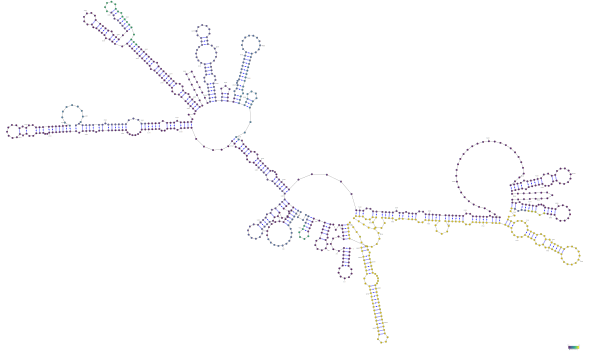

In [102]:
seq = fps_sequences[name_gfp]
folded = RNA.fold_compound(seq)
sstructure, mfe = folded.mfe()

rna_feature_choice = 'tir'
rna_feature_expanded = np.ones(len(seq))
for i, r in df_gfp.iterrows():
    rna_feature_expanded[int(r['start_position']):] = r[rna_feature_choice]
draw_rna_nucolor_varna(sstructure, seq, rna_feature_expanded,
                       out_file=f'data/24_analyse_RBS_data_joint/{rna_feature_choice}_gfp.png',
                       resolution=20, 
                       palette='viridis', # 'RdBu'
                       caption=f'{rna_feature_choice} [{rna_feature_expanded.min():.2f}, {rna_feature_expanded.max():.2f}]',
                       algorithm='naview')

# Merge RBS Calc + RNA df's 

In [103]:
def process_rna_dfs(df, name):
    df = df.rename(columns={'tir': 'TIR'}) # [[c for c in df.columns if c in df.columns]]
    seq = fps_sequences[name]
    folded = RNA.fold_compound(seq)
    sstructure, mfe = folded.mfe()
    df['initial_fold'] = sstructure
    df['used_mRNA_sequence'] = seq
    df["ARN count (mRNA)"] = count_ARN_motifs(seq)
    df["AAN count (mRNA)"] = count_AAN_motifs(seq)
    df["ARNn count (mRNA)"] = count_ARNn(seq)
    df['Identity'] = name
    df['Is mRNA'] = True
    
    return df

df['Identity'] = 'Reis et al. 2020'
df['Is mRNA'] = False
df_gfp = process_rna_dfs(df_gfp, name_gfp)
df_cyRFP = process_rna_dfs(df_cyRFP, name_cyRFP)
df_gfp_single = df_gfp.iloc[[np.argmax(df_gfp['TIR'])]]
df_cyRFP_single = df_cyRFP.iloc[[np.argmax(df_cyRFP['TIR'])]]

In [104]:
df_all = pd.concat([df_gfp_single, df_cyRFP_single, df], ignore_index=True)

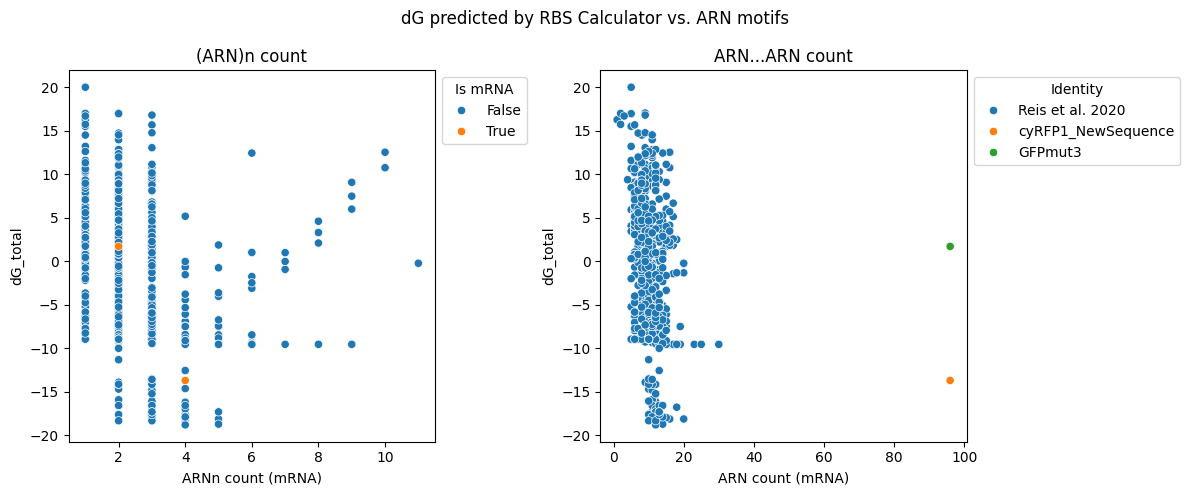

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
g = sns.scatterplot(df_all.sort_values('Is mRNA'), x="ARNn count (mRNA)", y="dG_total", hue='Is mRNA', ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
axs[0].set_title('(ARN)n count')
g = sns.scatterplot(df_all.sort_values('Is mRNA'), x="ARN count (mRNA)", y="dG_total", hue='Identity', ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
axs[1].set_title('ARN...ARN count')
plt.suptitle('dG predicted by RBS Calculator vs. ARN motifs')
plt.tight_layout()